In [60]:
#ALL IMPORTS
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import warnings
import matplotlib.cbook


In [61]:
# Open files and Load DATA
sns.set_theme()
with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\latestStats.json") as f:
    data = json.load(f)

with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\ETHZ-AP\\availableServers.json") as f:
    servers = json.load(f)


In [62]:
# # Convert list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
servers_df = pd.DataFrame(servers)

# # Convert the avg_latency column to numeric and save it back to the dataframe
df['avg_latency'] = pd.to_numeric(df['avg_latency'].str.replace('ms', ''))
#print(type(int(servers_df['_id'][0])))
servers_df['_id'] = pd.to_numeric(servers_df['_id'])

# Convert 'hops_number' column to numeric
df['hops_number'] = pd.to_numeric(df['hops_number']).astype(int)

# Remove the timestamp from the _id column and save it back to the dataframe as "serverId_pathId"
df['_id'] = df['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))


In [69]:
# Used to create the legend and color stuff

# List of unique destinations in DataFrame
destinations = df['_id'].str.split('_', expand=True)[0].unique()
df['dest'] = df['_id'].str.split('_', expand=True)[0]

# Create a DataFrame with the minimum and maximum hops for each destination
destination_hops_info = df.groupby('dest')['hops_number'].agg(['min', 'max']).reset_index()

# Compute max over 'max' column and min over 'min' column
max_hops = destination_hops_info['max'].max()
min_hops = destination_hops_info['min'].min()
num_hops = max_hops - min_hops + 1
colormap = cm.get_cmap('Set1', num_hops)

# Create a dictionary to map each destination to its color palette
colormap_dict = {}
for destination in destinations:
    # print("ITERATION #", destination)
    min_hops = destination_hops_info[destination_hops_info['dest'].str.startswith(destination)]['min'].iloc[0]
    max_hops = destination_hops_info[destination_hops_info['dest'].str.startswith(destination)]['max'].iloc[0]
    colormap_dict[destination] = {hops: colormap(i) for i, hops in enumerate(range(min_hops, max_hops + 1))}

# Function to assign colors based on destination and hops_number
def assign_color(row):
    destination = row['_id'].split('_')[0]
    hops = row['hops_number']
    return colormap_dict[destination][hops]

# Apply the function to create the 'color' column
df['color'] = df.apply(assign_color, axis=1)
warnings.filterwarnings("ignore",category=UserWarning)

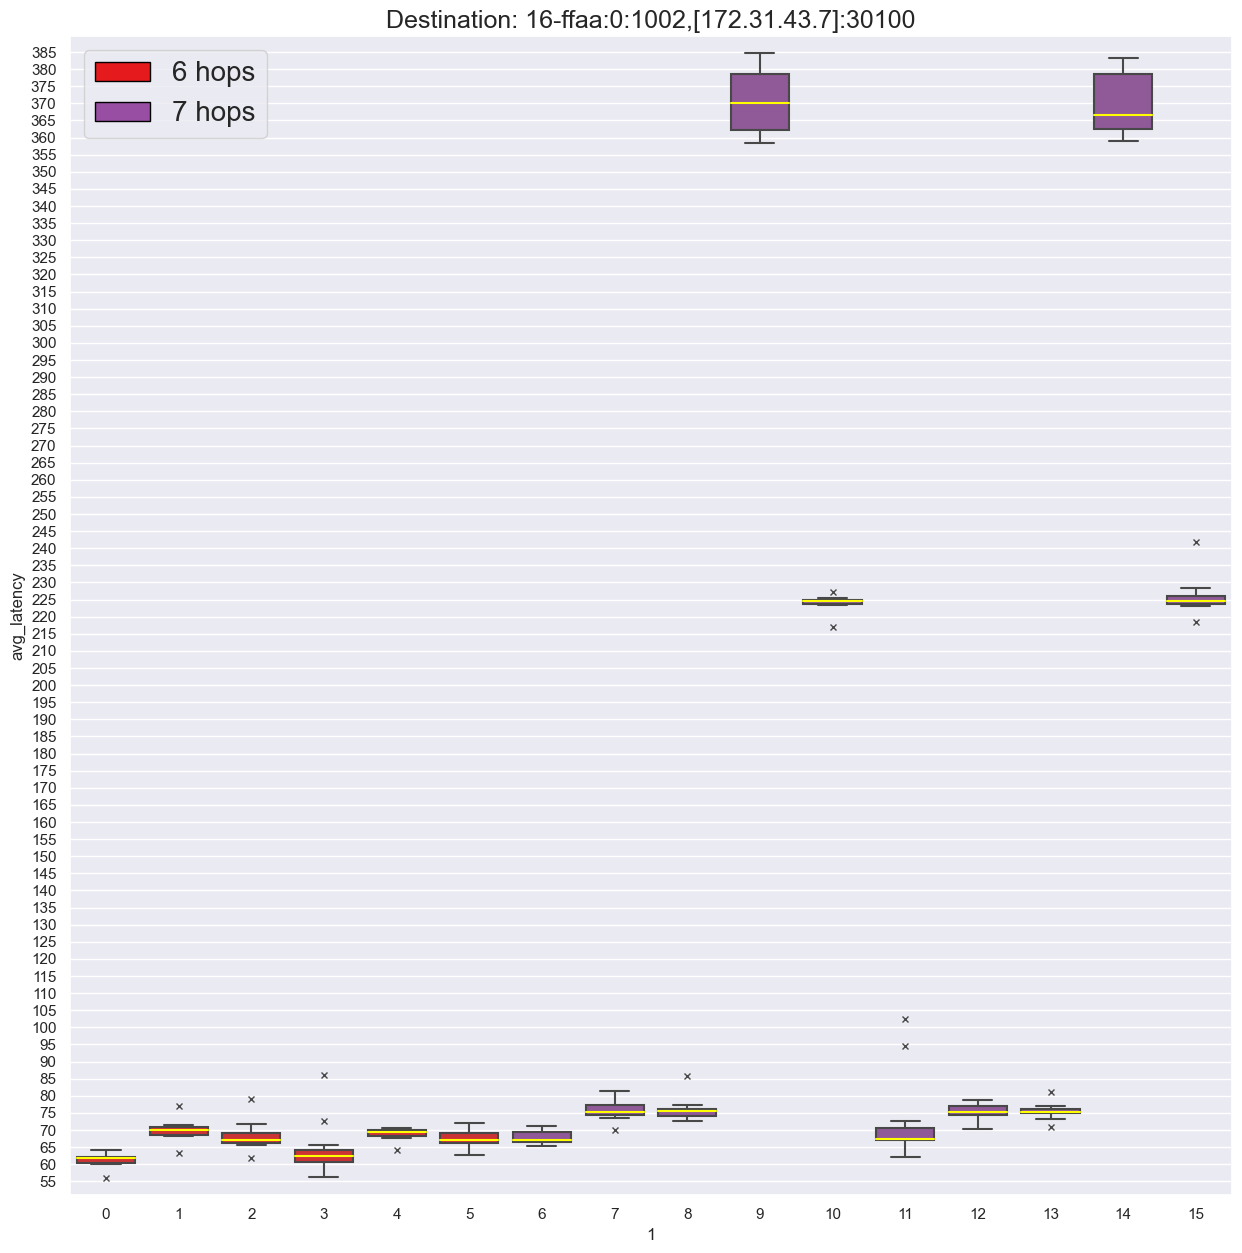

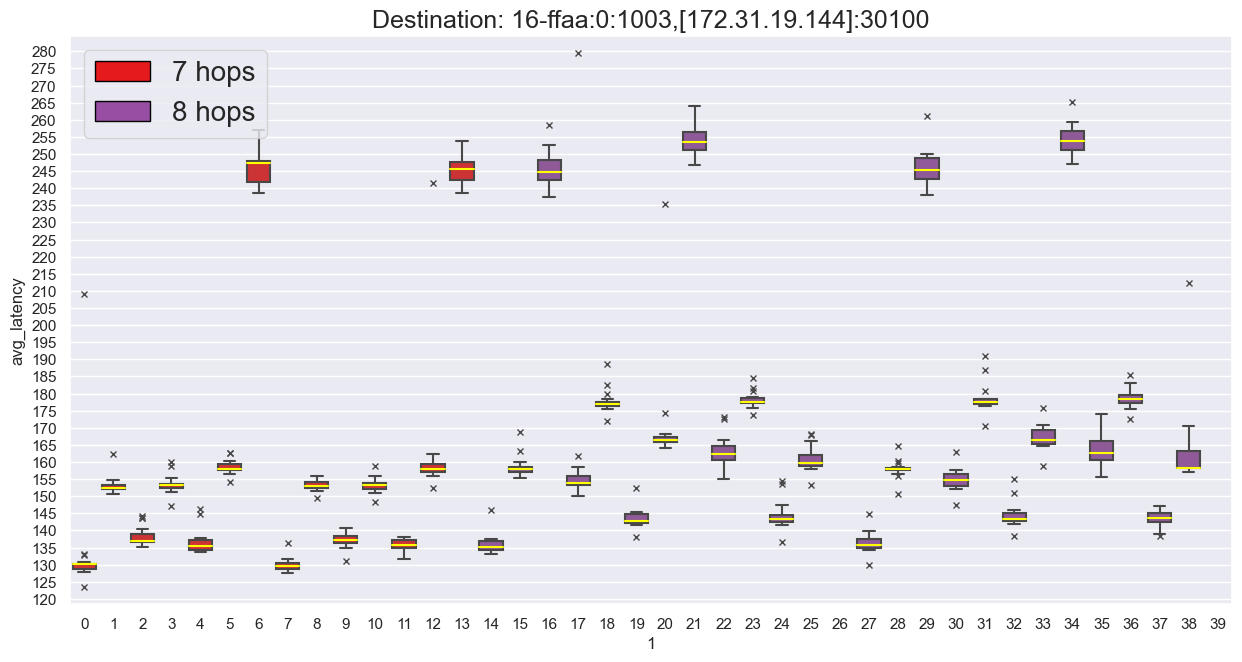

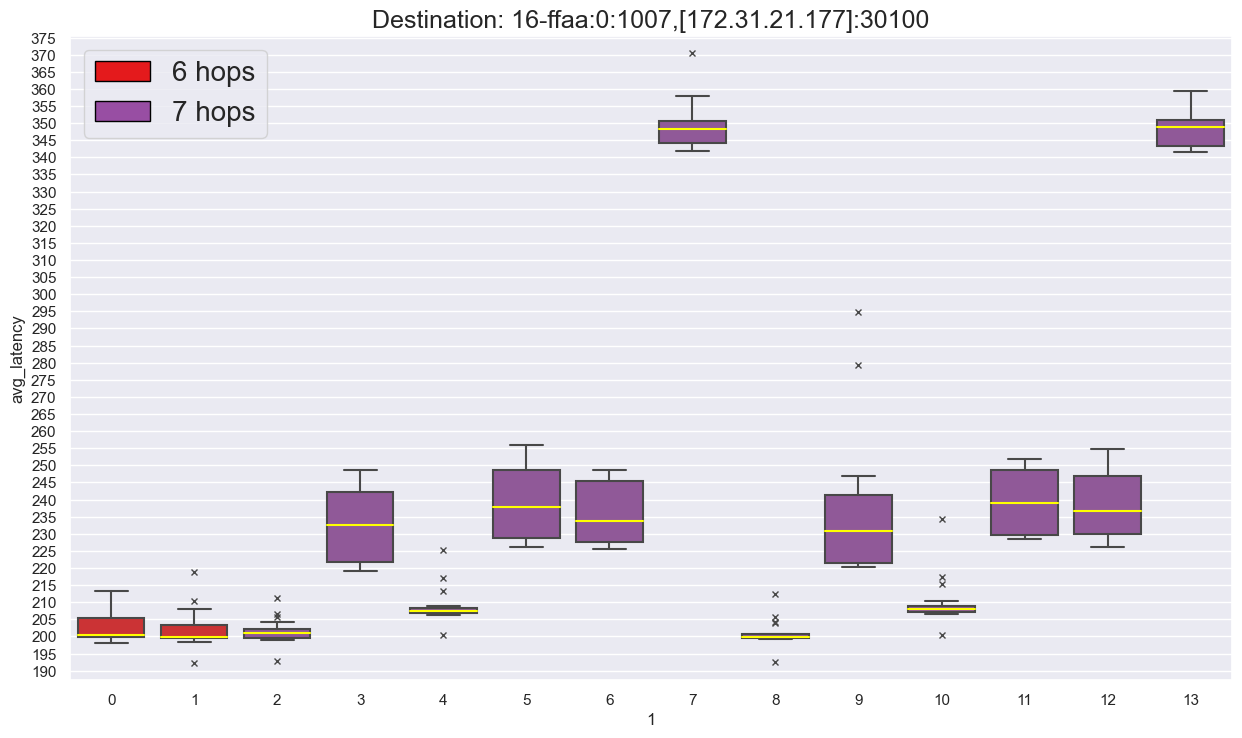

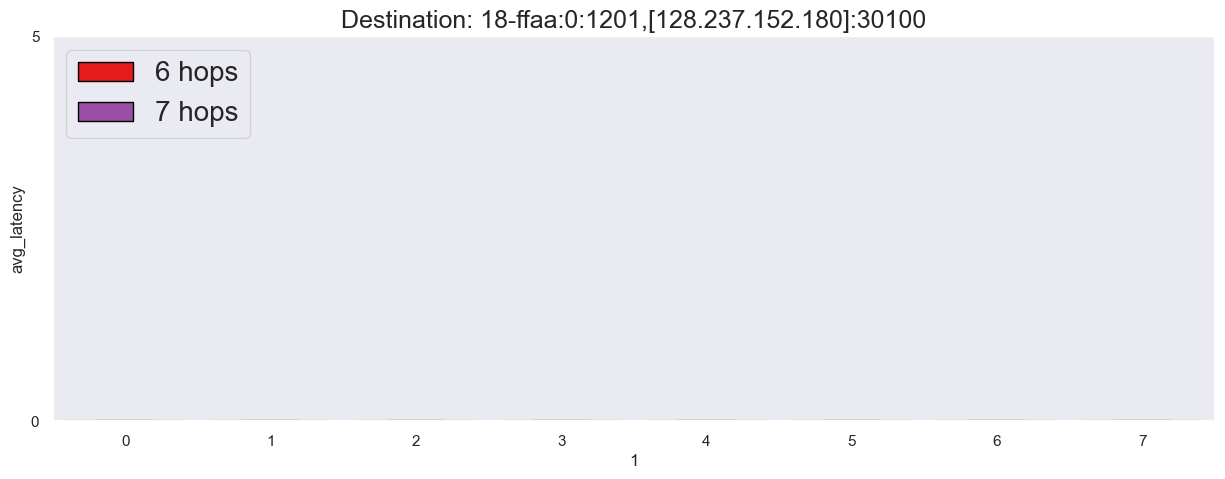

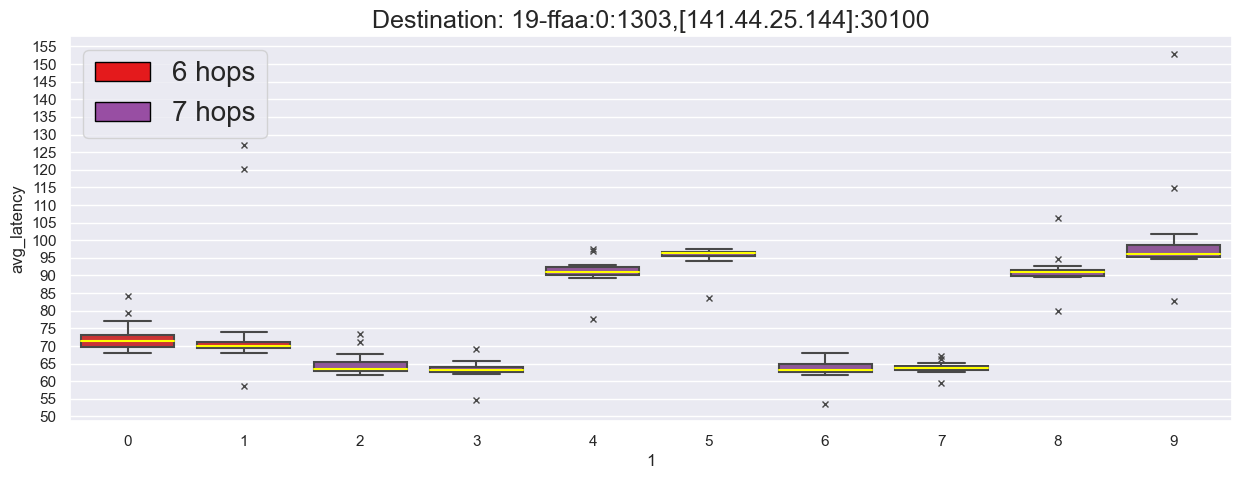

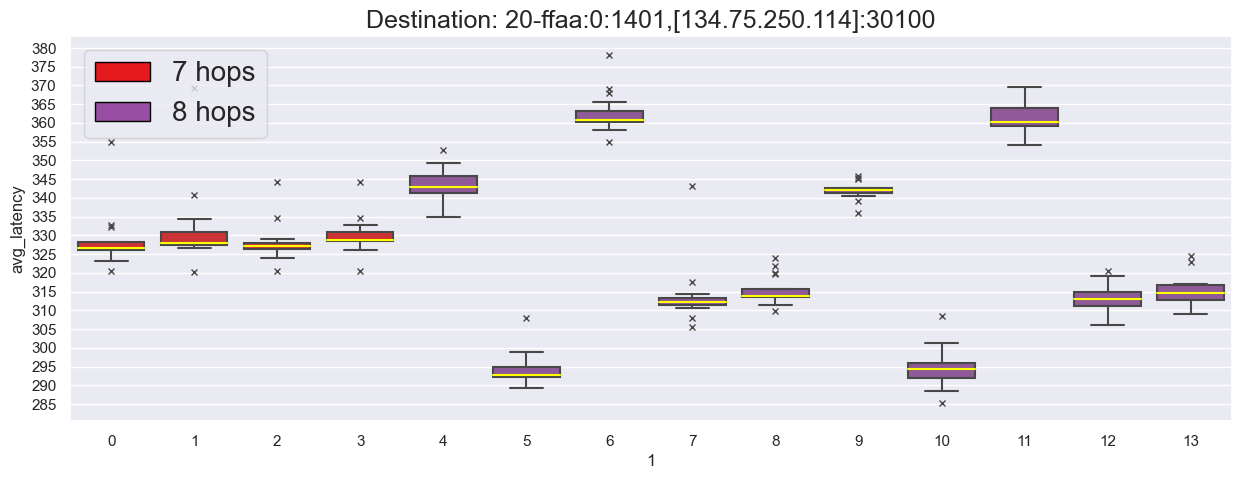

In [66]:
# # THIS IS THE CODE FOR THE PLOT OF THE AVERAGE LATENCY FOR EACH PATH FOR EACH DESTINATION. (WHISKER PLOT)

# Create subplots with 2 rows and 3 columns
# fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 70))

# Flatten the axes array to iterate over each subplot
# axes = axes.flatten()
custom_ticks = []

for i in range(0, 400, 5):
    custom_ticks.append(i)

# Iterate over destinations and create a graph for each
# Iterate over destinations and create a graph for each
for destination in destinations:
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()

    # Filter the DataFrame for the current destination and minimum number of hops +1 
    data = df[df['_id'].str.startswith(destination) & (df['hops_number'] <= min_hops+1)]

    min_latency = data['avg_latency'].min()
    max_latency = data[data['avg_latency'] <= 400]['avg_latency'].max()
    
    lower_bound = max(0, min_latency-5)
    upper_bound = min(400, max_latency+5)

    # print(max_latency)

    graph_height = upper_bound - lower_bound
    
    graph_height = graph_height/22.5 if not (graph_height/22.5) - 5 <= 0 else 5

    # Create a new figure for each destination
    fig, ax = plt.subplots(figsize=(15, graph_height))

    ax.set_yticks(custom_ticks, [str(tick) for tick in custom_ticks])
    ax.set_xlabel("PathID")
    ax.set_ylabel("Average Latency (ms)")

    ax.set_ylim([lower_bound, upper_bound])

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    # Create a sub DataFrame with all the ids for the current destination
    sub_df = [d for i,d in enumerate(data['_id'].unique())]

    # Create a list of colors for each pathID in the current destination
    box_color = [data[data['_id'] == id]['color'].iloc[0] for id in sub_df]

    # Create a dictionary mapping colors to number of hops
    color_hops_dict = {color: data[data['color'] == color]['hops_number'].iloc[0] for color in set(box_color)}

    sorted_color_hops_dict = {k: v for k, v in sorted(color_hops_dict.items(), key=lambda item: item[1])}

    # Create the whisker plot for the current destination
    sns.boxplot(data=data, x=data['_id'].str.split('_', expand=True)[1], y="avg_latency", palette=box_color, flierprops={"marker": "x"}, medianprops={"color" : "yellow"}, ax=ax)

    # Create a custom legend using the unique colors in the box_color list
    legend_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') for color in sorted_color_hops_dict.keys()]

    legend_labels = [f"{sorted_color_hops_dict[color]} hops" for color in set(sorted_color_hops_dict.keys())]
    legend_labels.sort(key=lambda x: int(x.split()[0]))

    ax.legend(legend_handles, legend_labels, loc='upper left', prop={'size': 20})  # Add the legend to the subplot

    ax.set_title(f"Destination: {server}", fontsize=18)  # Set the title for the subplot

    # Show the current figure
    plt.show()

In [67]:
#Creating a dictionary with the number of destinations for each number of hops

hops_destinations = {}

real_min = -1
higher_min = -1

num_dest = len(destinations)
for destination in destinations:
    min_hops = df[df['_id'].str.startswith(destination)]['hops_number'].min()
    if min_hops < real_min or real_min == -1:
        real_min = min_hops
    if min_hops > higher_min or higher_min == -1:
        higher_min = min_hops
    if min_hops in hops_destinations:
        hops_destinations[min_hops] = int(hops_destinations.get(min_hops, 0) + 1)
    else:
        hops_destinations[min_hops] = int(1)

list_of_hops = [i for i in range(real_min, higher_min+1, 1)]

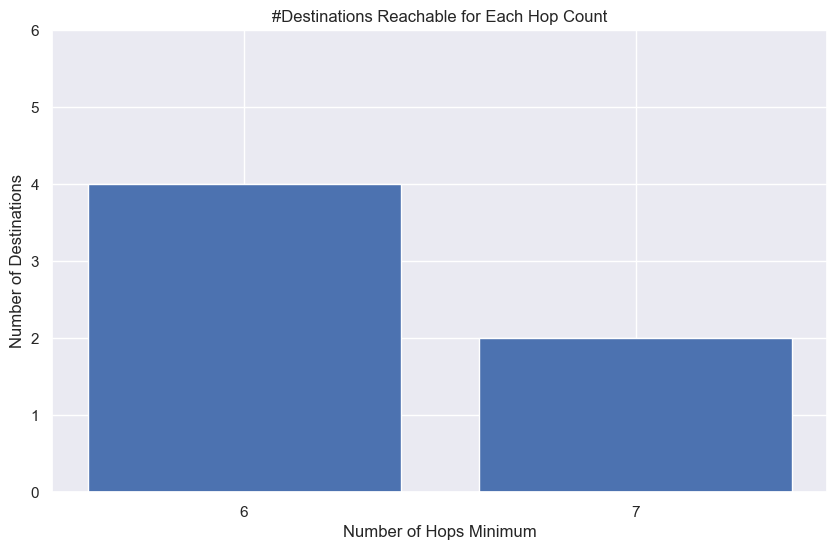

In [68]:
# Create a bar chart with #destination reachable for each hop count
plt.figure(figsize=(10, 6))
plt.bar(hops_destinations.keys(), hops_destinations.values())
plt.xticks(list_of_hops, [str(hops) for hops in list_of_hops])
plt.yticks([i for i in range(0, num_dest+1, 1)])
# Set the labels and title
plt.xlabel('Number of Hops Minimum')
plt.ylabel('Number of Destinations')
plt.title('#Destinations Reachable for Each Hop Count')

# Show the plot
plt.show()


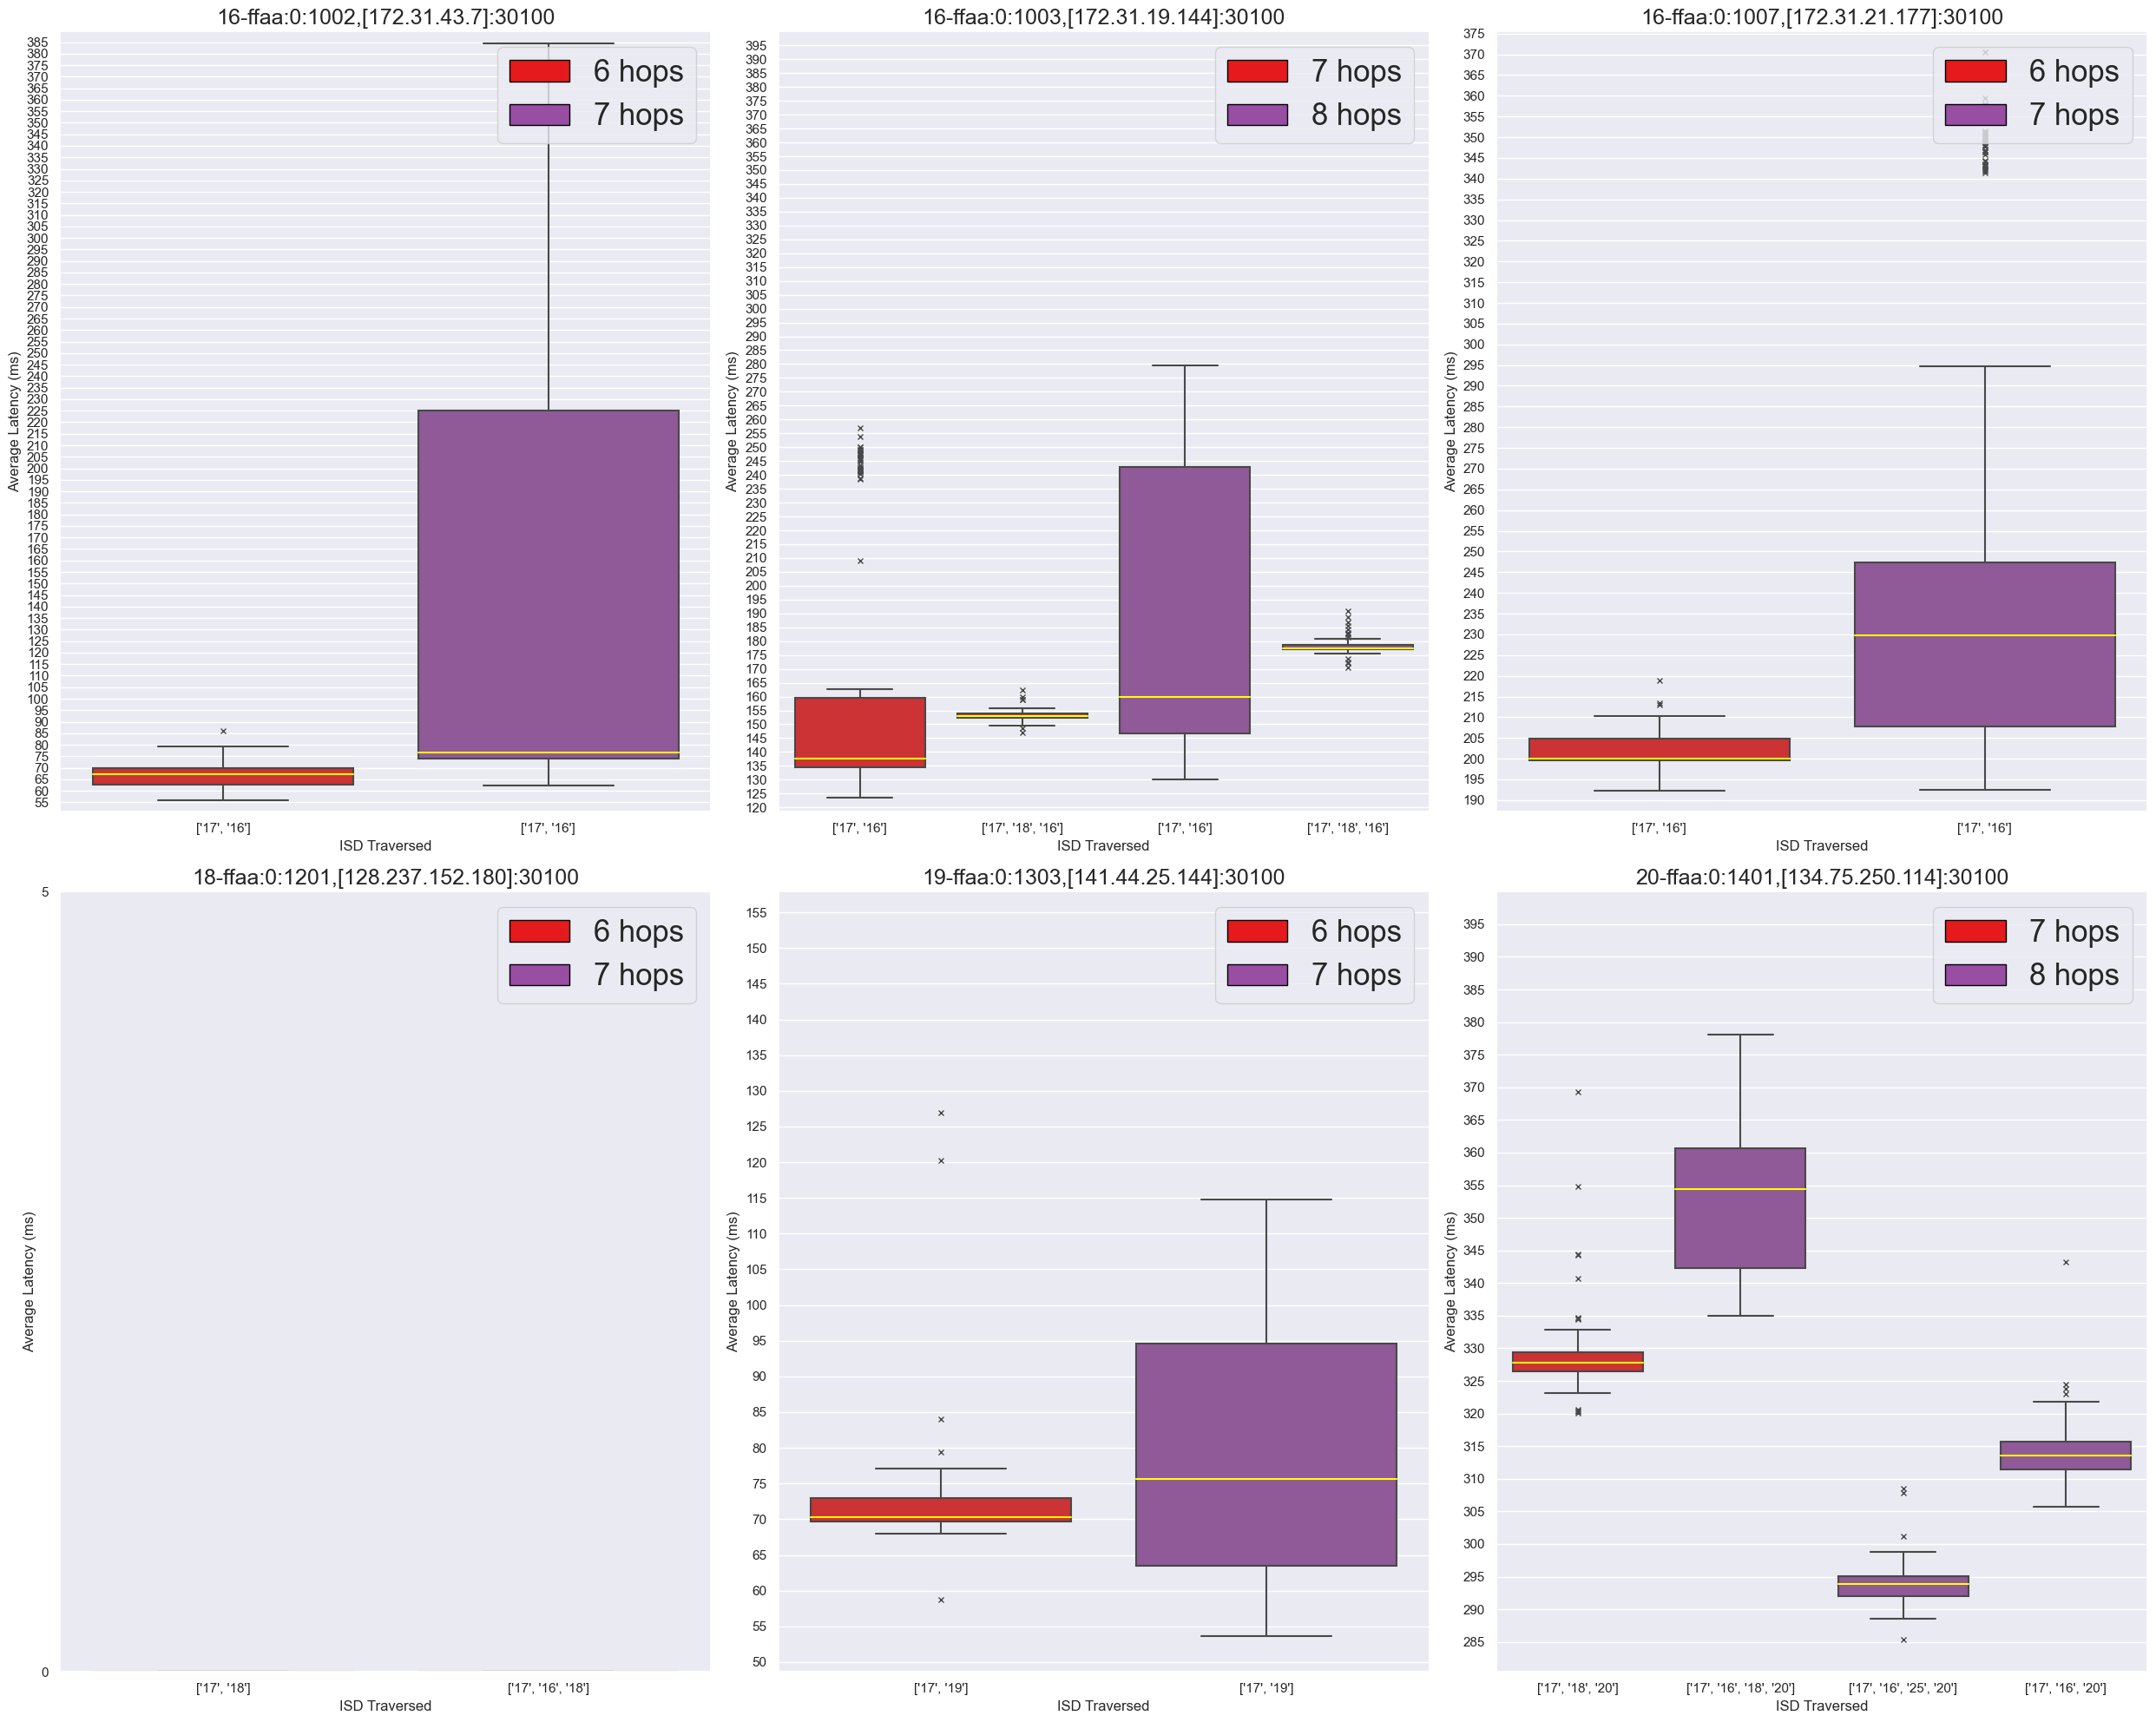

In [77]:
#Latency measured per ISD, grouped by hop count, destination fixed

# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))


# Filter the DataFrame to include only the necessary columns
filtered_df = df[['_id', 'avg_latency', 'isolated_domains', 'hops_number', 'color']]

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()
custom_ticks = []

for i in range(0, 400, 5):
    custom_ticks.append(i)

# Iterate over destinations and create a graph for each
for i, destination in enumerate(destinations):
    ax = axes[i]  # Get the current subplot
    ax.set_yticks(custom_ticks, [str(tick) for tick in custom_ticks])
    
    min_hops = filtered_df[filtered_df['_id'].str.startswith(destination)]['hops_number'].min()

    # Filter the DataFrame for the current destination and minimum number of hops 
    data = filtered_df[filtered_df['_id'].str.startswith(destination) & (filtered_df['hops_number'] <= min_hops+1)]

    #print(data)
    data = data.copy()
    
    data['isolated_domains'] = data['isolated_domains'].apply(tuple)
    data['x_value'] = data.apply(lambda row: (row['isolated_domains'], row['hops_number']), axis=1)

    #print(data_groupedby_isd_and_hops)

    # Create a sub DataFrame with all the isds for the current destination
    sub_df = [d for _,d in enumerate(data['x_value'].unique())]

    #print(sub_df)
    # Create a list of colors, It retrieves the color of the ISD with the minimum number of hops
    box_color = [data[data['x_value'] == domain]['color'].iloc[0] for domain in sub_df]

    #print(box_color)

    # Create a dictionary mapping colors to number of hops
    color_hops_dict = {color: data[data['color'] == color]['hops_number'].iloc[0] for color in set(box_color) if color is not None and not data[data['color'] == color].empty}

    #print(color_hops_dict)

    # Create the whisker plot for the current destination
    sns.boxplot(data=data, x=data['x_value'], y="avg_latency", palette=box_color, flierprops={"marker": "x"}, medianprops={"color" : "yellow"}, ax=ax)
    
    sorted_color_hops_dict = {k: v for k, v in sorted(color_hops_dict.items(), key=lambda item: item[1])}
  
    # Create a custom legend using the unique colors in the box_color list
    legend_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black') for color in sorted_color_hops_dict.keys()]

    legend_labels = [f"{sorted_color_hops_dict[color]} hops" for color in set(sorted_color_hops_dict.keys())]
    legend_labels.sort(key=lambda x: int(x.split()[0]))
    
    ax.legend(legend_handles, legend_labels, loc='upper right', prop={'size': 25})  # Add the legend to the subplot
    ax.set_xlabel("ISD Traversed")
    ax.set_ylabel("Average Latency (ms)")
    
    min_latency = data['avg_latency'].min()
    max_latency = data['avg_latency'].max()

    ax.set_ylim([max(0, min_latency-5), min(400, max_latency+5)])

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    ax.set_title(f"{server}", fontsize=18)  # Set the title for the subplot

    ax.set_xticklabels([str(list(tick[0])) for tick in data['x_value'].unique()])

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()


In [ ]:
# Perform aggregation on the bandwidth columns
df['avg_bandwidth_cs_MTU'] = pd.to_numeric(df['avg_bandwidth_cs_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
df['avg_bandwidth_sc_MTU'] = pd.to_numeric(df['avg_bandwidth_sc_MTU'].str.replace('Mbps', ''), errors='coerce').fillna(0)
df['avg_bandwidth_cs_64'] = pd.to_numeric(df['avg_bandwidth_cs_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)
df['avg_bandwidth_sc_64'] = pd.to_numeric(df['avg_bandwidth_sc_64'].str.replace('Mbps', ''), errors='coerce').fillna(0)


In [ ]:
# Group by destination and pathID, and compute the mean of each bandwidth column
grouped_df = df.groupby(['_id', 'hops_number', 'color'])[['avg_bandwidth_cs_MTU', 'avg_bandwidth_sc_MTU', 'avg_bandwidth_cs_64', 'avg_bandwidth_sc_64']].mean().reset_index().sort_values(by='_id', key=lambda col: col.str.replace('_', '').astype(int))
print(grouped_df)
custom_ticks = []
value = 0

while value < 40:
    custom_ticks.append(value)
    value += 2.5

      _id  hops_number                                              color  \
0     1_0            6  (0.8941176470588236, 0.10196078431372549, 0.10...   
1     1_1            6  (0.8941176470588236, 0.10196078431372549, 0.10...   
12    1_2            6  (0.8941176470588236, 0.10196078431372549, 0.10...   
23    1_3            6  (0.8941176470588236, 0.10196078431372549, 0.10...   
34    1_4            6  (0.8941176470588236, 0.10196078431372549, 0.10...   
..    ...          ...                                                ...   
201  6_35            9                               (0.6, 0.6, 0.6, 1.0)   
202  6_36            9                               (0.6, 0.6, 0.6, 1.0)   
203  6_37            9                               (0.6, 0.6, 0.6, 1.0)   
204  6_38            9                               (0.6, 0.6, 0.6, 1.0)   
205  6_39            9                               (0.6, 0.6, 0.6, 1.0)   

     avg_bandwidth_cs_MTU  avg_bandwidth_sc_MTU  avg_bandwidth_cs_64  \
0  

NameError: name 'grouped_df' is not defined

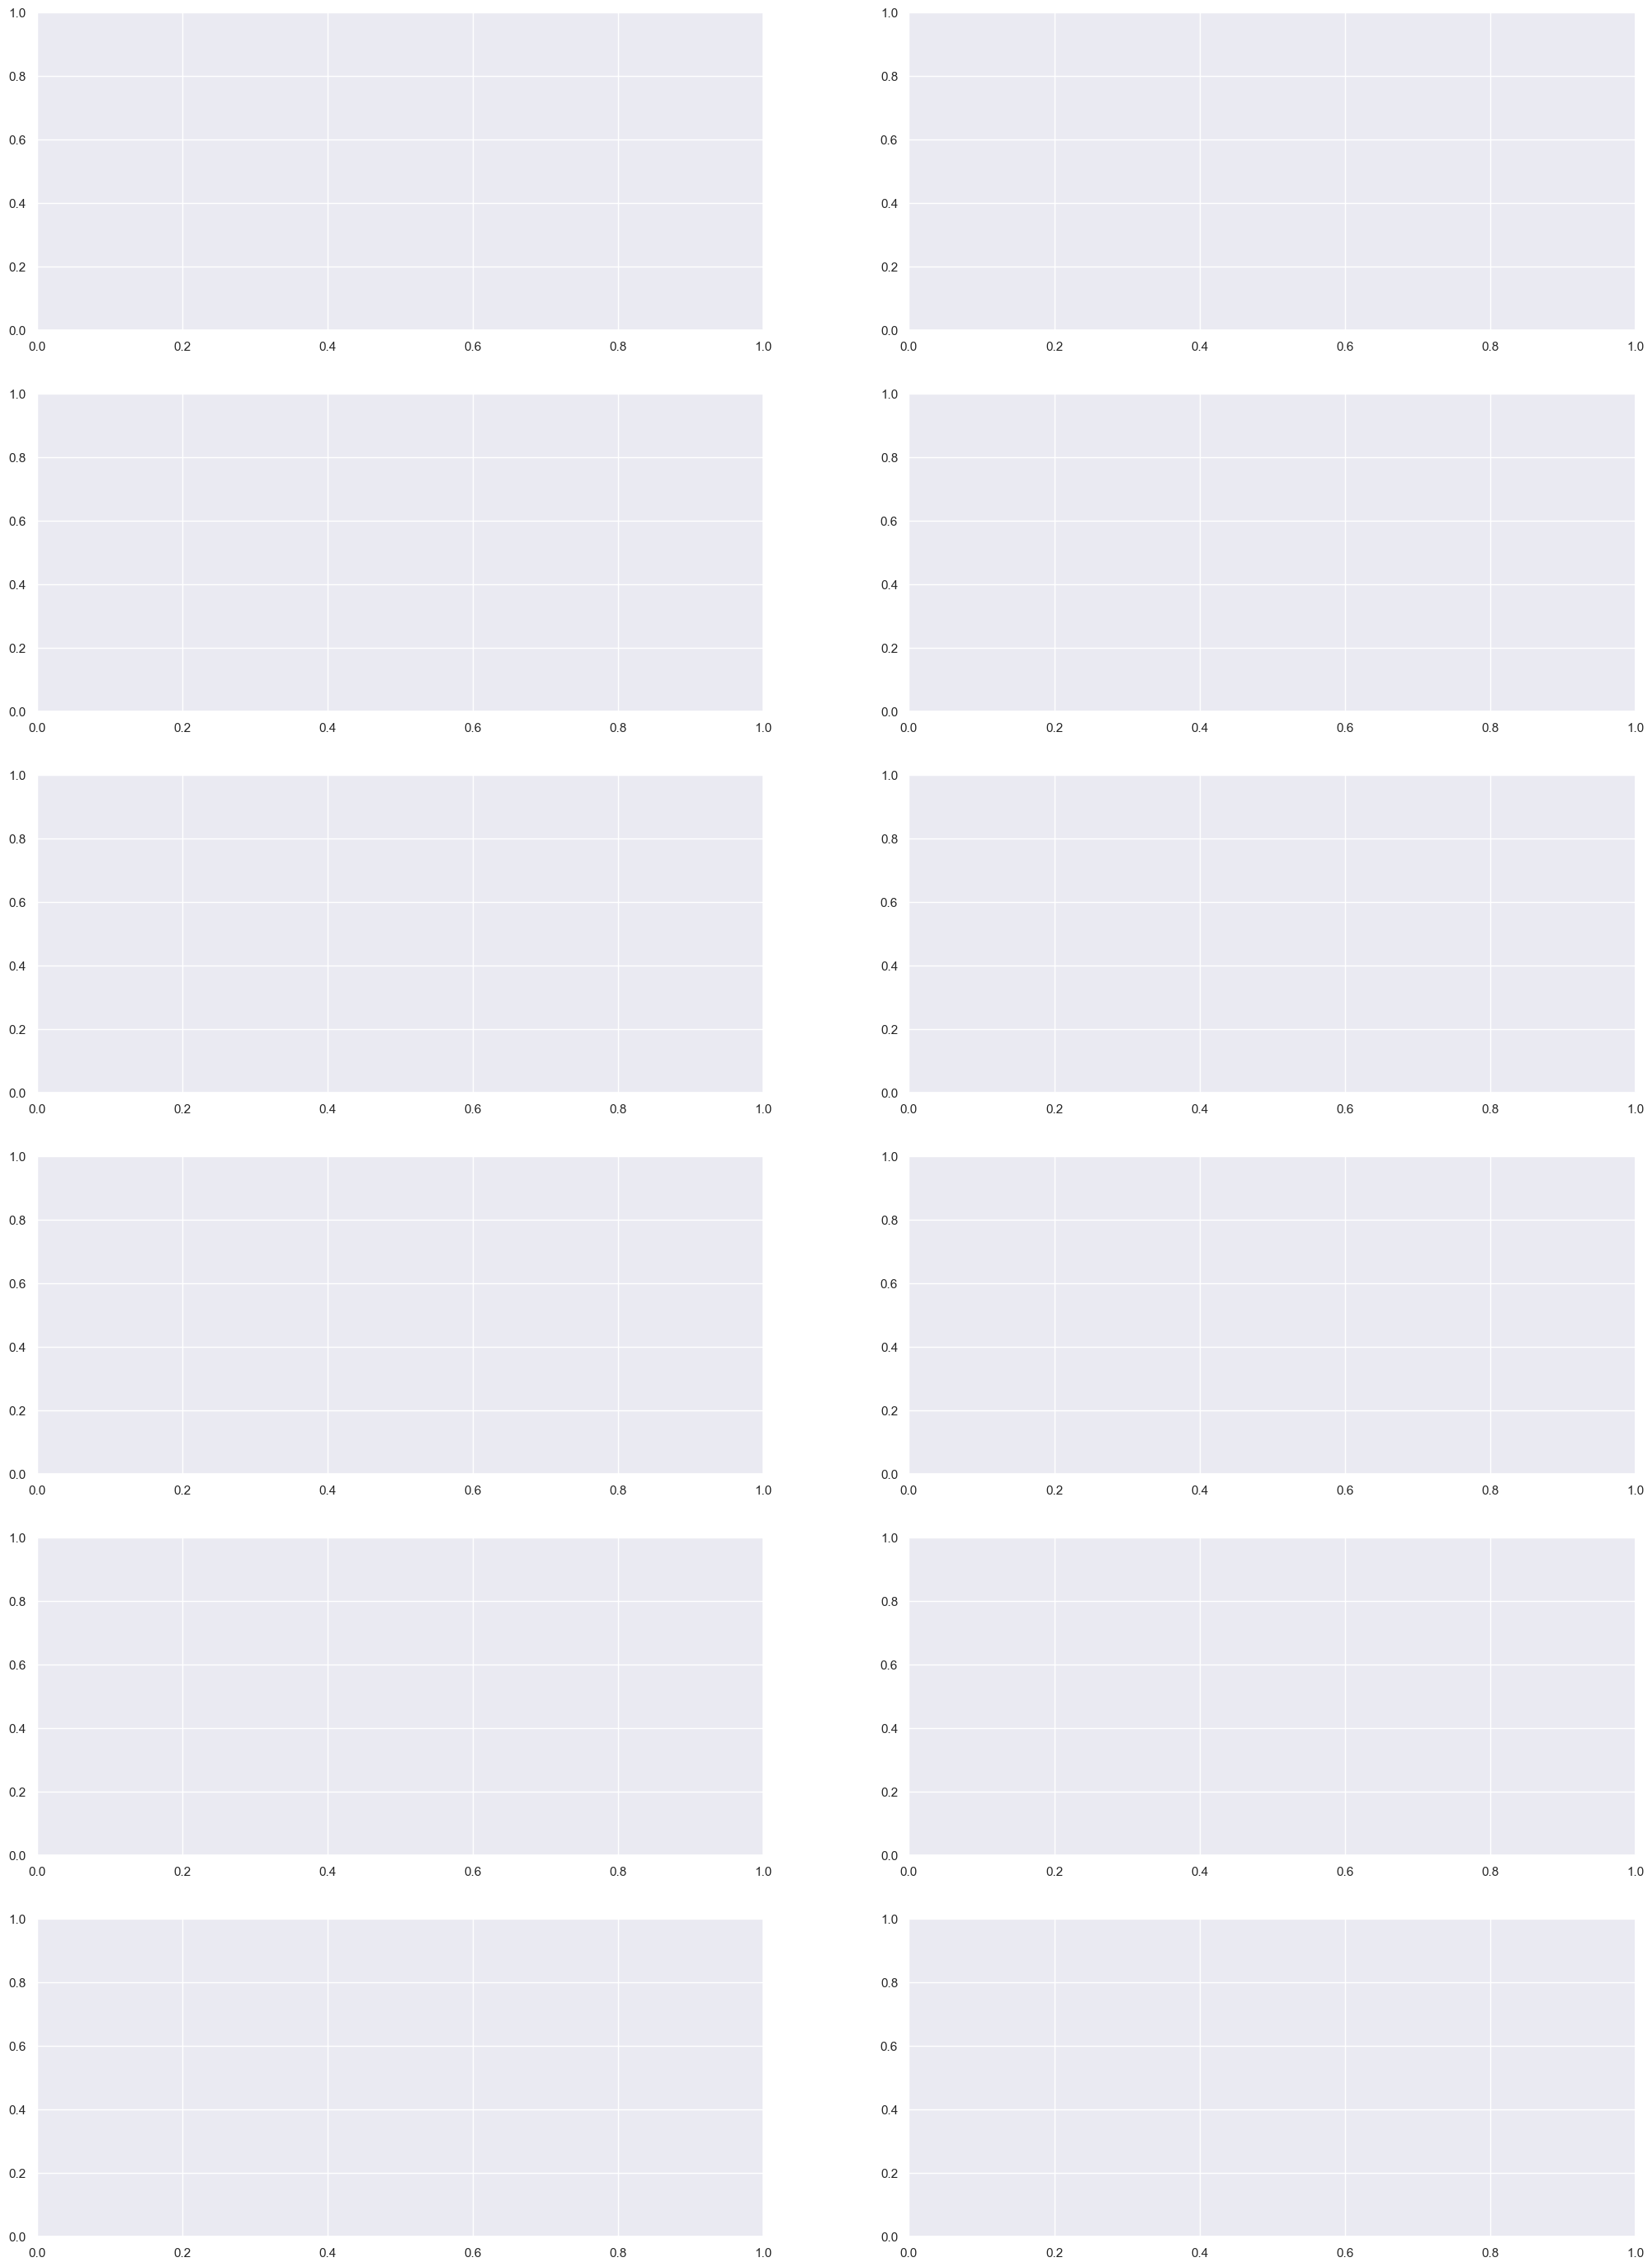

In [78]:
# Create subplots with 2 rows and 1 column
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(25, 35))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()
i = 0
# Iterate over the destinations
for destination in destinations:
    # Get the data for the current destination
    min_hops = grouped_df[grouped_df['_id'].str.startswith(destination)]['hops_number'].min()
    data = grouped_df[grouped_df['_id'].str.startswith(destination) & (grouped_df['hops_number'] <= min_hops+1)]

    # Create the subplots for upstream and downstream bandwidth
    ax1 = axes[i]
    ax2 = axes[i+1]
    
    i += 2 

    # Create Gaussians for MTU packet size
    sns.boxplot(data=data, x='_id', y='avg_bandwidth_cs_MTU', ax=ax1, label='MTU')
    sns.boxplot(data=data, x='_id', y='avg_bandwidth_cs_64', ax=ax1, label='64 bytes')

    # Create Gaussians for 64 bytes packet size
    sns.boxplot(data=data, x='_id', y='avg_bandwidth_sc_MTU', ax=ax2, label='MTU')
    sns.boxplot(data=data, x='_id', y='avg_bandwidth_sc_64', ax=ax2, label='64 bytes')

    # Gets the source address of the current destination
    server = servers_df[servers_df['_id'] == int(destination)]['source_address'].iloc[0]

    # Set the titles and labels
    ax1.set_title(f"Destination {server} - Upstream")
    ax2.set_title(f"Destination {server} - Downstream")

    ax1.set_ylabel("Avg Bandwidth (Mbps) - CS")
    ax2.set_ylabel("Avg Bandwidth (Mbps) - SC")

    ax1.set_xlabel("PathID")
    ax2.set_xlabel("PathID")

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()


In [ ]:

for id in df['_id'].unique():
    d = df[df['_id'] == id]
    f, ax = plt.subplots(1,1, figsize=(10,5))
    ax.hist(d['avg_latency'])
    ax.set_title(id)
    # sns.violinplot(d, hue_order=[True, False], split=True, ax=ax, orient='h')
